## python勉強会　第18回　sklearn1 20200904 

In [1]:
#各ライブラリのインポート
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

### 本回では、これまでの講義の復習も兼ねて、データ分析のチュートリアルを行う。
### 扱う題材は、kaggleのチュートリアルとして有名な、タイタニック号の生存者予測問題。性別、年齢、１部屋あたりの宿泊人数などから生存者と死亡者を分類する。
### 参考URL：
https://qiita.com/suzumi/items/8ce18bc90c942663d1e6  
https://nehori.com/nikki/2019/12/21/post-14065/#i



In [25]:
#まず、タイタニック号のデータをインポートする。
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
tmp = pd.read_csv("./gender_submission.csv")

#テストデータはSurvivedを合算しておく。
test_df
test_df = pd.concat([test_df,pd.DataFrame(tmp["Survived"])],axis=1)
test_df.shape


(418, 12)

### 【問題１】
### 学習データ（train）の各列の平均、分散、４分位点などの統計量を表示して、データの中身を確認してください。
### ヒント：train_df.(関数名)()の１行で書けます。
PassengerID:　乗客ID  
Survived: 　　生存結果 (1: 生存, 2: 死亡)  
Pclass: 　　　乗客の階級 1が一番位が高いそう  
Name: 　　 　 乗客の名前  
Sex: 　　　　 性別  
Age: 　　　　 年齢  
SibSp 　　 　 兄弟、配偶者の数。  
Parch 　　　　両親、子供の数。  
Ticket 　　　 チケット番号。  
Fare 　　　　 乗船料金。  
Cabin 　　　　部屋番号  
Embarked 　　 乗船した港　Cherbourg、Queenstown、Southamptonの３種類があります  


In [3]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 【問題2】
### train_df,test_dfの各列に欠損値（NaNなど）があるか確認してください。
### ヒント：pandasのisnullを使います。

In [26]:
###ここで、学習データとテストデータに欠損値があるか調べます。
def nan_table(df): 
        null_val = df.isnull().sum()
        percent = 100 * df.isnull().sum()/len(df)
        kesson_table = pd.concat([null_val, percent], axis=1)
        kesson_table_ren_columns = kesson_table.rename(
        columns = {0 : '欠損数', 1 : '%'})
        return kesson_table_ren_columns
 
print("学習データ") 
print(nan_table(train_df))
print("テストデータ")
print(nan_table(test_df))

学習データ
             欠損数          %
PassengerId    0   0.000000
Survived       0   0.000000
Pclass         0   0.000000
Name           0   0.000000
Sex            0   0.000000
Age          177  19.865320
SibSp          0   0.000000
Parch          0   0.000000
Ticket         0   0.000000
Fare           0   0.000000
Cabin        687  77.104377
Embarked       2   0.224467
テストデータ
             欠損数          %
PassengerId    0   0.000000
Pclass         0   0.000000
Name           0   0.000000
Sex            0   0.000000
Age           86  20.574163
SibSp          0   0.000000
Parch          0   0.000000
Ticket         0   0.000000
Fare           1   0.239234
Cabin        327  78.229665
Embarked       0   0.000000
Survived       0   0.000000


### 【問題３】
### 欠損値や数値でないデータを補間してください。ただし、PassengerID、Name、Ticket、Cabinの情報は使いません。
### ヒント：male→0、femake→1など、変換する。

In [27]:
##ここに回答を記述する。

def data_cleaning(data):
    """
    titanicデータをクリージングする関数
    data:pandasDataFrame
    """
    data_copy = data.copy()
    #################################
    #使わない変数を落とすコードを書いてください。
    data_copy = data_copy.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
    
    ###############################
    #年齢でNaNがある部分を、学習データ、テストデータそれぞれの平均年齢で補間してください。
    data_copy["Age"]  = data_copy["Age"].fillna(data["Age"].mean())
    
    ###############################
    #テストデータの運賃でNaNがある部分を、平均値で補間してください。
    data_copy["Fare"] = data_copy["Fare"].fillna(data["Fare"].mean())
    
    ###############################
    #学習データのEmbarked（就航地）でNaNがある行を削除してください。
    data_copy = data_copy.dropna(subset=["Embarked"])
    
    ###############################
    #性別をmale=0、female=1として補間してください。
    data_copy["Sex"] = data_copy["Sex"].replace(["male", "female"], [0, 1])
    
    ##############################
    #EmbarkedをC=0、S=1、Q=2、として補間してください。
    data_copy["Embarked"] = data_copy["Embarked"].replace(["C", "S", "Q"], [0, 1, 2])
    ##############################
    return data_copy

#学習データとテストデータをそれぞれクレンジングします。
train_use = data_cleaning(train_df)
test_use = data_cleaning(test_df)

#クレンジングが完了したかどうかを確認します。
print("整形後の学習データ") 
print(nan_table(train_use))
print(train_use.head())
print("整形後のテストデータ")
print(nan_table(test_use))
print(test_use.head())




整形後の学習データ
          欠損数    %
Survived    0  0.0
Pclass      0  0.0
Sex         0  0.0
Age         0  0.0
SibSp       0  0.0
Parch       0  0.0
Fare        0  0.0
Embarked    0  0.0
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    0  22.0      1      0   7.2500         1
1         1       1    1  38.0      1      0  71.2833         0
2         1       3    1  26.0      0      0   7.9250         1
3         1       1    1  35.0      1      0  53.1000         1
4         0       3    0  35.0      0      0   8.0500         1
整形後のテストデータ
          欠損数    %
Pclass      0  0.0
Sex         0  0.0
Age         0  0.0
SibSp       0  0.0
Parch       0  0.0
Fare        0  0.0
Embarked    0  0.0
Survived    0  0.0
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Survived
0       3    0  34.5      0      0   7.8292         2         0
1       3    1  47.0      1      0   7.0000         1         1
2       2    0  62.0      0      0   9.6875         2        

### 【問題４】
### 学習データ（train）の各列を生存者と死亡者に分けて可視化・比較してください。
### また、可視化の結果から、生存者の特徴を１つ見つけてください。
### ヒント：seabornを使います。

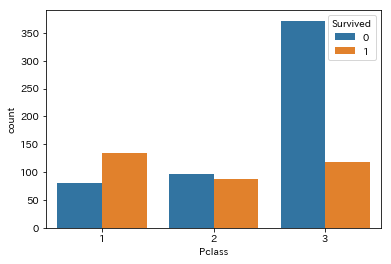

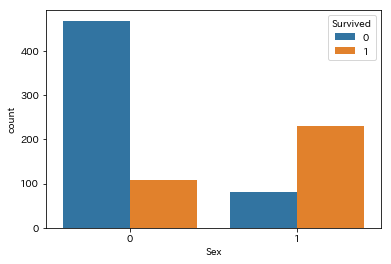

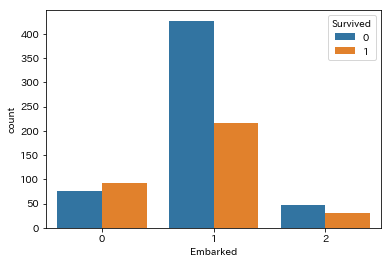

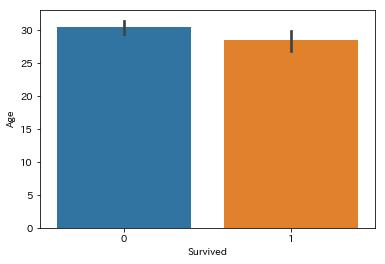

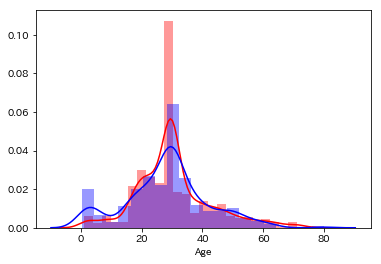

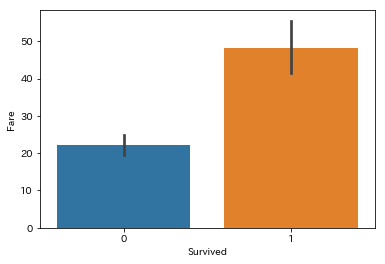

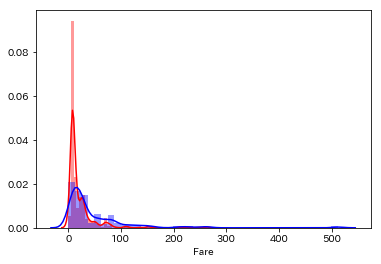

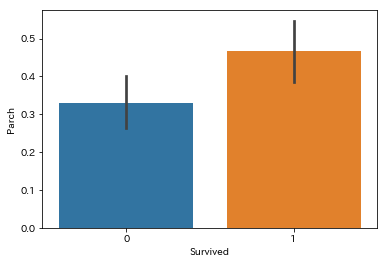

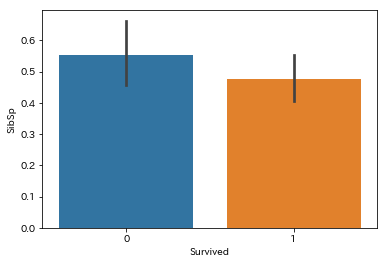

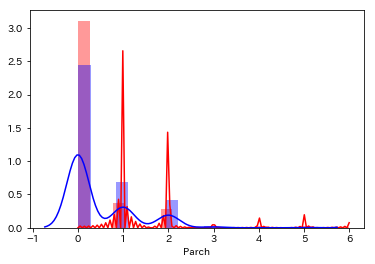

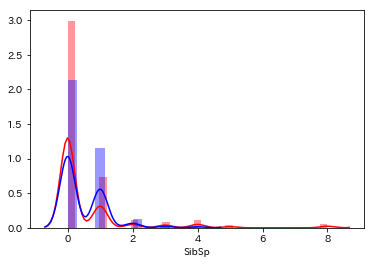

In [35]:
##ここに回答を記述する。

######################
#countplotを使う
#Pclass（宿泊のグレード、1が高価、3が普通）
plt.figure()
sns.countplot(x="Pclass",hue="Survived",data=train_use)

#性別
plt.figure()
sns.countplot(x="Sex",hue="Survived",data=train_use)

#就航地
plt.figure()
sns.countplot(x="Embarked",hue="Survived",data=train_use)


#####################
#ヒストグラムを作成する関数を作成する。
def hist_plot(select_name):
    """生存者と死亡者を分けて、ヒストグラムで表示する関数です。
    select_name：可視化したい変数名
    """
    plt.figure()
    sns.distplot(train_use[train_use["Survived"]==0][select_name],label="death",color="red")
    sns.distplot(train_use[train_use["Survived"]==1][select_name],label="survived",color="blue")
#####################
#年齢
plt.figure()
sns.barplot(x="Survived",y="Age",data=train_use)

#ヒストグラム
hist_plot("Age")

#####################
#運賃
plt.figure()
sns.barplot(x="Survived",y="Fare",data=train_use)

#ヒストグラム
hist_plot("Fare")

#####################
#家族構成
plt.figure()
sns.barplot(x="Survived",y="Parch",data=train_use)

plt.figure()
sns.barplot(x="Survived",y="SibSp",data=train_use)

#ヒストグラム
hist_plot("Parch")
hist_plot("SibSp")




### 【問題５】
### ここから決定木系の手法を用いて、生存者の分類を行います。予測を行います。枠で囲われている部分を埋めてください。
### 注）厳密にモデル作成するには、CV（クロスバリデーション）を行って、モデルのハイパーパラメータを最適化しますが、今回は行いません。クロスバリデーションやハイパーパラメータに関しては、以下のURLを参考にしてみてください。  
https://qiita.com/Takayoshi_Makabe/items/d35eed0c3064b495a08b

In [48]:
#scikit-learnに入っている、アンサンブル×決定木系の機械学習モデルをインポートする。
#今回は、ランダムフォレストを使います。
from sklearn.ensemble import AdaBoostClassifier,ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split

##################################
#train_dfを学習データと評価データに分けます。また、学習、評価、テストデータを、目的変数（Y）と説明変数（X）に分けます。
X = train_use.drop(["Survived"],axis=1)
Y = train_use["Survived"]

train_x,valid_x,train_y,valid_y = train_test_split(X,Y,test_size=0.2)

test_x = test_use.drop(["Survived"],axis=1)
test_y = test_use["Survived"]


#ランダムフォレストを変数として定義します。
#分類モデルではclf（classifiar）という変数をよく用います。
clf = RandomForestClassifier()

for num in range(10):
    #####################################
    #モデルを学習させます。
    clf.fit(train_x,train_y)
    #####################################

    #学習が完了したモデルに評価データを突っ込んで、正解率を見てみます。
    print(str(num+1)+"回目、Validate Accuray:%s" % clf.score(valid_x,valid_y))




1回目、Validate Accuray:0.8370786516853933
2回目、Validate Accuray:0.8202247191011236
3回目、Validate Accuray:0.8426966292134831
4回目、Validate Accuray:0.8146067415730337
5回目、Validate Accuray:0.8146067415730337
6回目、Validate Accuray:0.8539325842696629
7回目、Validate Accuray:0.8258426966292135
8回目、Validate Accuray:0.8426966292134831
9回目、Validate Accuray:0.8146067415730337
10回目、Validate Accuray:0.8370786516853933


### 【問題６】
### 学習したモデルを使って、テストデータを分類してください。また分類結果として、テストデータの正答率および混同行列を求めてください。混同行列はヒートマップとして可視化してください。
### ヒント：混同行列の可視化にはseabornを使います。

Test Accuracy:{%s} 0.8205741626794258


Text(0.5, 16.0, 'Predict label')

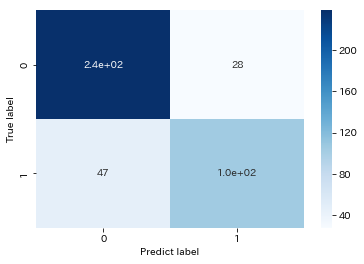

In [33]:
#混同行列を求める関数のインポート
from sklearn.metrics import confusion_matrix

#学習完了したモデルに、テストデータを入れて、正解率を表示してください。
print("Test Accuracy:{%s}",clf.score(test_x,test_y))

#テストデータの混同行列を出力してください。
con_mat = confusion_matrix(test_y,clf.predict(test_x))

plt.figure()
sns.heatmap(con_mat,cmap="Blues",annot=True)
plt.ylabel("True label")
plt.xlabel("Predict label")


### 【オプション問題】
### テストデータの推論結果を元に、ROC曲線を描いてください。
https://note.nkmk.me/python-sklearn-roc-curve-auc-score/


0.7922932330827068


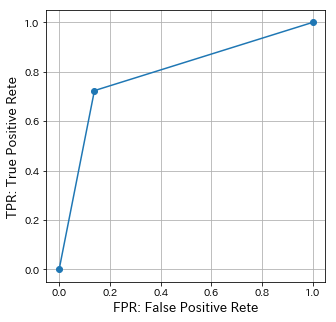

In [51]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thres = roc_curve(test_y,clf.predict(test_x))

print(roc_auc_score(test_y,clf.predict(test_x)))
plt.figure(figsize = (5, 5)) #単一グラフの場合のサイズ比の与え方
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False Positive Rete', fontsize = 13)
plt.ylabel('TPR: True Positive Rete', fontsize = 13)
plt.grid()
plt.show()